# Data cleaning
1. Investigate variable mapping for consistency of units of measuremet (UOM)
2. Convert measurements to UK (METRIC) units
3. Replace ages > 89 with median age for these patients (HIPAA regulations)
4. Introduce binary surrogate 'airway' variable
5. Replace individual GCS components with their summed GCS score
6. Filter data for anomalies according to clinically advised value ranges
7. Explore distributions with histograms and boxplots - possibly further anomaly removal
8. Append columns containing admission-level data (weight, height, callout time)
9. Calculate how long before callout time each measurement was taken - hrs_bRFD column


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# display options
pd.reset_option('all')
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

Import the data and remove some itemids that have been declared unwanted elsewhere.

In [2]:
df = pd.read_pickle('pickle_vars/chartevents_for_cohort.pkl.xz')
df = df.drop(columns=['ROW_ID','CGID','STORETIME','WARNING','ERROR','RESULTSTATUS','STOPPED'])
df = df[~df.ITEMID.isin([226062,226063,227516,228151,224027,762,920,1394,4187,3486,3485,4188])]

### Variable mapping and Units of Measurement

**UOM consistency check**

Initial variable mapping (excluding venous po2 and pco2, and diastolic bp.)

In [3]:
variable_mapping = dict()
variable_mapping['fio2'] = [226754, 227009, 227010,223835]
variable_mapping['resp'] = [220210, 224688, 224689, 224690]
variable_mapping['po2'] = [226770,227039,220224] 
variable_mapping['pco2'] = [220235,227036]
variable_mapping['temp'] = [223761, 223762]
variable_mapping['hr'] = [220045]
variable_mapping['bp'] = [220050, 220059, 220179, 224167, 225309, 227243, 226850, 226852]
variable_mapping['k'] = [220640, 227464, 227442, 226772, 226535]
variable_mapping['na'] = [220645, 226534, 226776]
variable_mapping['hco3'] = [224826, 226759, 227443]
variable_mapping['spo2'] = [220227, 220277, 226860,226861,226862,226863,226865,228232]
variable_mapping['bun'] = [225624, 227000, 227001]
variable_mapping['airway'] = [223838, 224832, 224391, 227810,223837, 224829]
variable_mapping['gcs'] = [220739, 223900, 223901, 226755, 226756, 226757, 226758, 227011, 227012, 227013, 227014,228112]
variable_mapping['creatinine'] = [220615, 226752, 227005]
variable_mapping['pain'] = [223791, 227881]
variable_mapping['haemoglobin'] = [220228]
variable_mapping['peep'] = [220339, 224699, 224700]
variable_mapping['weight'] = [226512]
variable_mapping['height'] = [226730]

Lets see which of these itemids are present in the data, as well as the UOMs to describe them:

In [4]:
itemid_summary = pd.DataFrame()
itemid_summary['Variable'] = variable_mapping.keys()

itemids = []
UOMs = []
labels = []
unitnames = []

for var in list(variable_mapping.keys()):
    itemids.append(df[df.ITEMID.isin(variable_mapping[var])].ITEMID.unique())
    UOMs.append(df[df.ITEMID.isin(variable_mapping[var])].VALUEUOM.unique())
    labels.append(df[df.ITEMID.isin(variable_mapping[var])].LABEL.unique())
    unitnames.append(df[df.ITEMID.isin(variable_mapping[var])].UNITNAME.unique())    
    
itemid_summary['ITEMID'] = itemids
itemid_summary['VALUEUOM'] = UOMs
itemid_summary['LABEL'] = labels
itemid_summary['UNITNAME'] = unitnames
itemid_summary

,Variable,ITEMID,VALUEUOM,LABEL,UNITNAME
0,fio2,[223835],[nan],[Inspired O2 Fraction],[nan]
1,resp,"[220210, 224689, 224688, 224690]",[insp/min],"[Respiratory Rate, Respiratory Rate (spontaneo...",[insp/min]
2,po2,"[220224, 227039]",[mmHg],"[Arterial O2 pressure, PO2_ApacheIV]",[mmHg]
3,pco2,[220235],[mmHg],[Arterial CO2 Pressure],[mmHg]
4,temp,"[223761, 223762]","[?F, ?C]","[Temperature Fahrenheit, Temperature Celsius]","[?F, ?C]"
5,hr,[220045],[bpm],[Heart Rate],[bpm]
6,bp,"[220179, 220050, 225309]",[mmHg],"[Non Invasive Blood Pressure systolic, Arteria...",[mmHg]
7,k,"[227442, 227464]","[mEq/L, nan]","[Potassium (serum), Potassium (whole blood)]",[nan]
8,na,"[220645, 226534]","[mEq/L, nan]","[Sodium (serum), Sodium (whole blood)]",[nan]
9,hco3,[227443],"[mEq/L, nan]",[HCO3 (serum)],[nan]


From this we can see:
- many of the itemids are redundant for this extraction of the data
- temperature measurements are in deg C as well as deg F
- some measurements have missing UOMs

Lets convert temperature measured in deg F (itemid [223761]) to deg C

In [5]:
conv_temp_F = lambda temp_F: (temp_F-32)/1.8 ## convert from Farenhiet (MIMIC) to Celcius (GICU)
df['VALUENUM'] = df.apply(lambda row: conv_temp_F(row['VALUENUM']) if (row['ITEMID']==223761) else row['VALUENUM'],axis=1)

After checking for consistency of units we have the following mapping:

In [6]:
variable_mapping = dict()
variable_mapping['fio2'] = [223835]
variable_mapping['resp'] = [220210, 224689, 224688, 224690]
variable_mapping['po2'] = [220224, 227039] 
variable_mapping['pco2'] = [220235]  
variable_mapping['temp'] = [223761,223762] # both IDs are still present, but we have converted the VALUENUMs to both deg C
variable_mapping['hr'] = [220045]
variable_mapping['bp'] = [220179, 220050, 225309]
variable_mapping['k'] = [227442, 227464]
variable_mapping['na'] = [220645, 226534]
variable_mapping['hco3'] = [227443]
variable_mapping['spo2'] = [220277, 220227, 228232]
variable_mapping['bun'] = [225624]
variable_mapping['airway'] = [224391, 224832, 223837, 223838, 224829, 227810]
variable_mapping['gcs'] = [220739, 223900, 223901]
variable_mapping['creatinine'] = [220615]
variable_mapping['pain'] = [223791]
variable_mapping['haemoglobin'] = [220228]
variable_mapping['peep'] = [220339, 224700]
variable_mapping['weight'] = [226512]
variable_mapping['height'] = [226730]

Add a column that states which variable a measurement relates to

In [7]:
## define which ITEMIDs correspond to which variables.  
get_var = lambda it: [variable for variable,items in variable_mapping.items() if it in items][0]
all_itemids = [item for sublist in variable_mapping.values() for item in sublist]
var_id = {item: get_var(item) for item in all_itemids}
df['VARIABLE'] = df.ITEMID.apply(lambda itemid: get_var(itemid))

**Convert measurements to equivalent units for UK**

In [8]:
%%time
units_to_convert = ['creatinine', 'po2', 'pco2', 'bun']

conv_crea = lambda crea: 88.42 * crea  ## convert from mg/dL (MIMIC) to umol/L (GICU)
conv_bg = lambda gas: 0.1333 * gas   ## convert blod gas from mmHg (MIMIC) to kPa (GICU)
conv_bun = lambda bun: 0.3571 * bun  ## convert mg/dL (MIMC) to mmol/L (GICU)

def _convert(var, val):
    
    new_val = None
    if var=='creatinine':
        new_val = conv_crea(val)
    elif var=='po2' or var=='pco2':
        new_val = conv_bg(val)
    elif var=='bun':
        new_val = conv_bun(val)
        
    return new_val

df['VALUENUM'] = df.apply(lambda row: _convert(row['VARIABLE'], row['VALUENUM']) if (row['VARIABLE'] in units_to_convert and row['VALUENUM']!=None) else row['VALUENUM'],axis=1)

CPU times: user 1min 38s, sys: 3.6 s, total: 1min 42s
Wall time: 1min 42s


### Handling Age, Airway and GCS

**Ages**

Patients older than 89 have been assigned ages 300+ (due to HIPAA regulations), as shown below

In [9]:
sub_ages = df.groupby('SUBJECT_ID',as_index=False).agg(age=('age',min))
sub_ages[sub_ages.age>89].age.value_counts()

age
300.0    574
302.0     19
301.0     16
306.0     12
304.0     12
305.0     11
307.0      7
308.0      6
303.0      6
310.0      2
309.0      1
Name: count, dtype: int64

In [10]:
sub_ages[sub_ages.age==300].age.count() / sub_ages[sub_ages.age>=300].age.count()

0.8618618618618619

~86% of patients over age 89 are projected to age 300 (on HOSP admission). Ages over 300 indicate that a patient has been readmitted (Hosp level) a number of years later.
Since we only know that the median age of patients over 89 is 91.4 (from MIMIC-III documentation), we will take 91 to be the age of all of these patients:

In [11]:
df['age'] = df.age.replace([300,301,302,303,304,305,306,307,308,309,310],91)

**Airway**

We now work out if airway is patent...
* We simply use presence of ETT as proxy for non-patent airway.
* remove PEEP (it would be possible to stipulate PEEP + ETT -> non-patent, but simultaneity calculation is an unecessary complication).

In [13]:
%%time
airway_reduced = df[df.VARIABLE=='airway'].groupby(['ICUSTAY_ID','CHARTTIME'],as_index=False).agg(hrs_bd=('hrs_bd',np.random.choice),
                                                                                                  hrs_SA=('hrs_SA',np.random.choice), 
                                                                                                  HADM_ID=('HADM_ID',np.random.choice),
                                                                                                  SUBJECT_ID=('SUBJECT_ID',np.random.choice),
                                                                                                  ITEMID=('ITEMID',min),
                                                                                                  VALUE=('VALUE',np.random.choice),
                                                                                                  VALUEUOM=('VALUEUOM',np.random.choice),
                                                                                                  INTIME=('INTIME',np.random.choice),
                                                                                                  OUTTIME=('OUTTIME',np.random.choice),
                                                                                                  LOS=('LOS',np.random.choice),
                                                                                                  LABEL=('LABEL',np.random.choice),
                                                                                                  UNITNAME=('UNITNAME',np.random.choice),
                                                                                                  cohort=('cohort',np.random.choice),
                                                                                                  in_h_death=('in_h_death',np.random.choice),
                                                                                                  in_icu_death=('in_icu_death',np.random.choice),
                                                                                                  readmit=('readmit',np.random.choice),
                                                                                                  outcome=('outcome',np.random.choice),
                                                                                                  VARIABLE=('VARIABLE',np.random.choice),
                                                                                                  DOB=('DOB',np.random.choice),
                                                                                                  sex=('sex',np.random.choice),
                                                                                                  age=('age',np.random.choice))

airway_reduced['VALUENUM'] = airway_reduced['ICUSTAY_ID'].apply(lambda x: 1.0)

CPU times: user 1min 11s, sys: 5.96 s, total: 1min 17s
Wall time: 1min 13s


Remove all PEEP and AIRWAY, add reduced airway back in

In [15]:
df = df[~df.VARIABLE.isin(['peep','airway'])]
df = pd.concat([df,airway_reduced])

**GCS scores**

There are three GCS scores:
- Eye Opening, scored out of 4
- Motor Response, scored out of 6
- Verbal Response, scored out of 5

In [17]:
df[df.VARIABLE=='gcs'].groupby('LABEL',as_index=False).agg(MAX=('VALUENUM',max),
                                                           MIN=('VALUENUM',min))

,LABEL,MAX,MIN
0,GCS - Eye Opening,4.0,1.0
1,GCS - Motor Response,6.0,1.0
2,GCS - Verbal Response,5.0,1.0


It appears that all of our GCS scores are within the acceptable range. Next we sum the GCS scores to give a total out of 15.

We can do this by grouping on charttime because all 3 GCS measurements are given the same charttime if they pertain to the same set.

In [18]:
%%time
gcs_summed = df[df.VARIABLE=='gcs'].groupby(['ICUSTAY_ID','CHARTTIME'],as_index=False).agg(ncpts=('VALUENUM',pd.Series.count),
                                                                                           VALUENUM=('VALUENUM',sum),
                                                                                           hrs_bd=('hrs_bd',np.random.choice),
                                                                                           hrs_SA=('hrs_SA',np.random.choice), 
                                                                                           HADM_ID=('HADM_ID',np.random.choice),
                                                                                           SUBJECT_ID=('SUBJECT_ID',np.random.choice),
                                                                                           ITEMID=('ITEMID',min),
                                                                                           VALUE=('VALUE',np.random.choice),
                                                                                           VALUEUOM=('VALUEUOM',np.random.choice),
                                                                                           INTIME=('INTIME',np.random.choice),
                                                                                           OUTTIME=('OUTTIME',np.random.choice),
                                                                                           LOS=('LOS',np.random.choice),
                                                                                           LABEL=('LABEL',np.random.choice),
                                                                                           UNITNAME=('UNITNAME',np.random.choice),
                                                                                           cohort=('cohort',np.random.choice),
                                                                                           in_h_death=('in_h_death',np.random.choice),
                                                                                           in_icu_death=('in_icu_death',np.random.choice),
                                                                                           readmit=('readmit',np.random.choice),
                                                                                           outcome=('outcome',np.random.choice),
                                                                                           VARIABLE=('VARIABLE',np.random.choice),
                                                                                           DOB=('DOB',np.random.choice),
                                                                                           sex=('sex',np.random.choice),
                                                                                           age=('age',np.random.choice))

CPU times: user 3min 39s, sys: 12.7 s, total: 3min 52s
Wall time: 3min 42s


Remove any summed GCS scores if they don't contain all 3 components

In [21]:
_frac_incomplete = sum(gcs_summed['ncpts']<3)/len(gcs_summed)
print("%.4f of gcs measures not complete." %_frac_incomplete)
gcs_summed_complete = gcs_summed[gcs_summed['ncpts']==3]

0.0127 of gcs measures not complete.


Remove all single GCS components and append the complete GCS values to the data. (VARIABLE='gcs' is now GCS total)

In [22]:
df = df[df.VARIABLE!='gcs']
gcs_summed_complete = gcs_summed_complete.drop(columns=['ncpts'])
df = pd.concat([df,gcs_summed_complete])

### Anomalies and distributions

**Measurement Anomaly removal**

First lets filter out measurments according to acceptable ranges proved by clinicians:

In [24]:
physical_limit = dict()
physical_limit['creatinine'] = (0.0, 4421.0) # scaled to UK measuremet
physical_limit['fio2'] = (0.0, 100.0)     
physical_limit['resp'] = (0.0,100.0)      
physical_limit['po2'] = (0.0,66.65) # scaled to UK measuremet
physical_limit['pco2'] = (0.0,66.65) # scaled to UK measuremet
physical_limit['temp'] = (30, 42)   
physical_limit['hr'] = (0.0, 250.0)  
physical_limit['bp'] = (0.0, 500.0) 
physical_limit['k'] = (0.0, 50.0)   
physical_limit['na'] = (0.0, 500.0)  
physical_limit['hco3'] = (0,100.0)    
physical_limit['spo2'] = (10.0, 100.0) 
physical_limit['bun'] = (0.0,107.13) # scaled to UK measuremet
physical_limit['gcs'] = (3.0, 15.0)  
physical_limit['pain'] = (0.0, 10.0) 
physical_limit['peep'] = (0.0, 50.0)          
physical_limit['haemoglobin'] = (0.0, 100.0)  
physical_limit['airway'] = (np.nan,np.nan)
physical_limit['weight'] = (30, 500) # kg - these are crude acceptable ranges - Investigate!
physical_limit['height'] = (100, 250) # cm

In [25]:
%%time

df['remove_col'] = df.apply(lambda row: 1 if (row['VALUENUM']>physical_limit[var_id[row['ITEMID']]][1] or row['VALUENUM']<physical_limit[var_id[row['ITEMID']]][0]) else 0, axis=1)
print("%d rows to remove:" %sum(df['remove_col']==1))
df = df[df['remove_col']==0]
df = df.drop(columns=['remove_col'])

2286 rows to remove:
CPU times: user 1min 50s, sys: 5.1 s, total: 1min 55s
Wall time: 1min 56s


Check for itemids in the data that are not in the variable mapping:

In [26]:
array1 = df.ITEMID.unique()
array2 = np.concatenate(list(variable_mapping.values()), dtype = int, casting='unsafe').ravel()
np.setdiff1d(array1, array2)

array([], dtype=int64)

**Inspecting variable Distributions**

Now inspect each variable by plotting:
- histograms which show distribution and skew
- boxplots which show outliers, defined by 1.5x(Q3-Q1)

In [27]:
# function to plot histogram + boxplot on same axis for x_var
def hist_box_plot(data_series, x_var, title=None, bins='auto', n_samples=None, frac_samples=None):
    data = data_series.sample(n_samples,frac_samples).values
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

    sns.boxplot(x=data, ax=ax_box)
    sns.histplot(x=data, bins=bins, kde=True, stat='density', ax=ax_hist)

    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    ax_hist.set(xlabel=x_var)
    if title: ax_box.set(title=title)
    f.savefig('figures/'+str(x_var)+'.png', dpi=500)

CPU times: user 34.7 s, sys: 5.22 s, total: 39.9 s
Wall time: 20.1 s


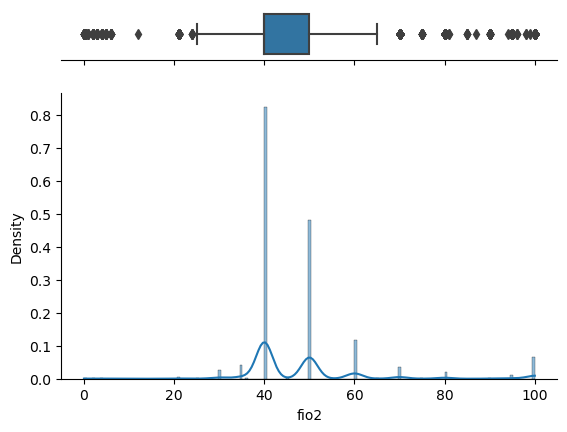

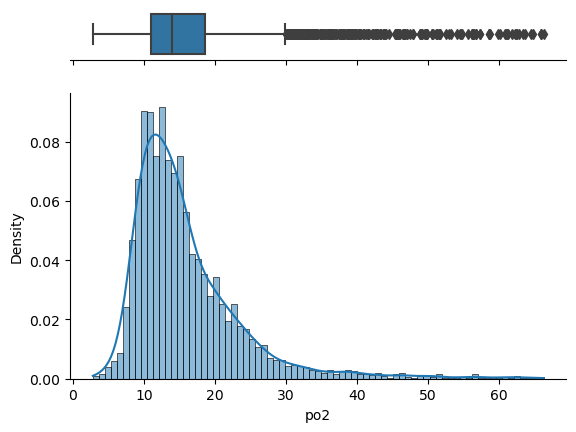

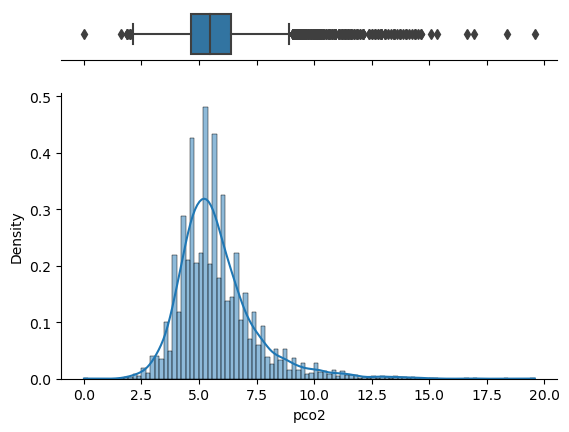

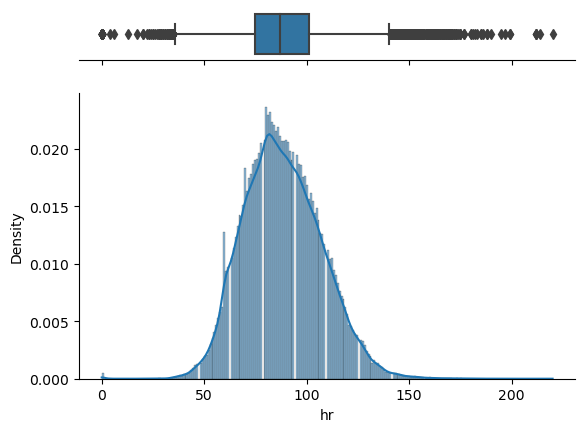

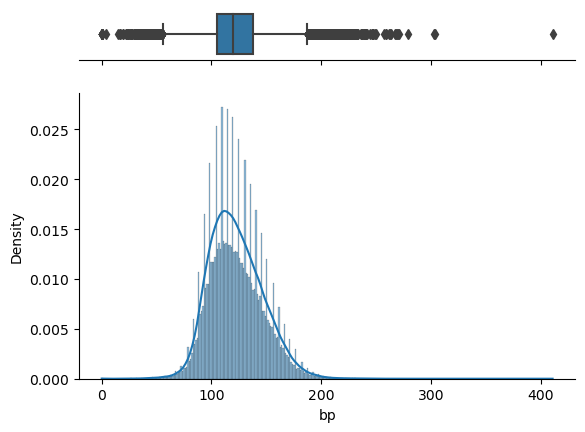

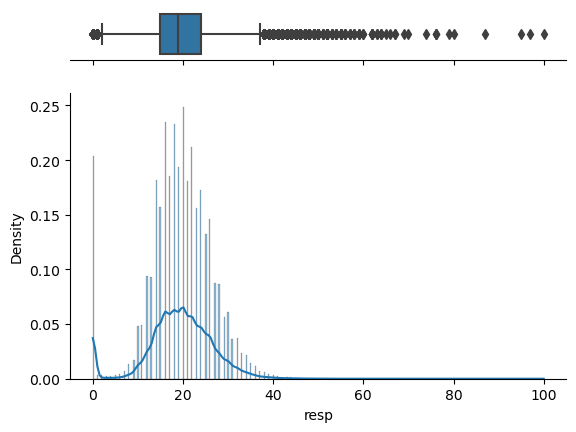

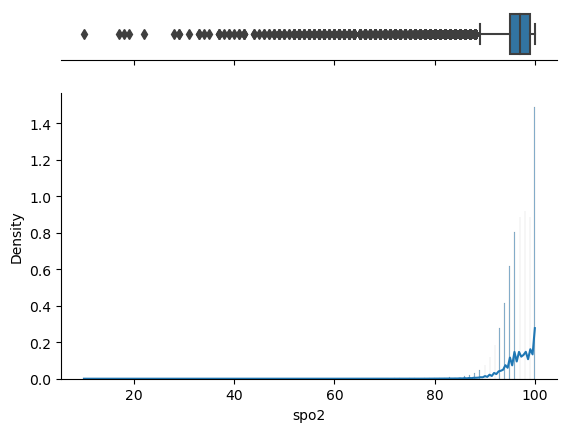

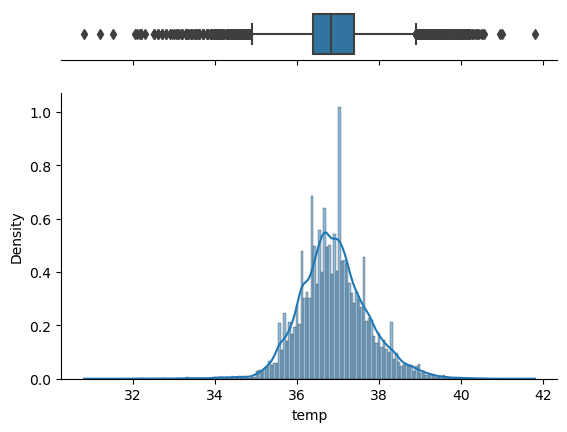

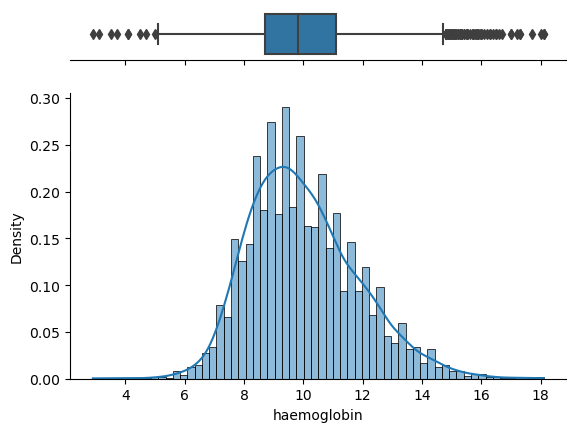

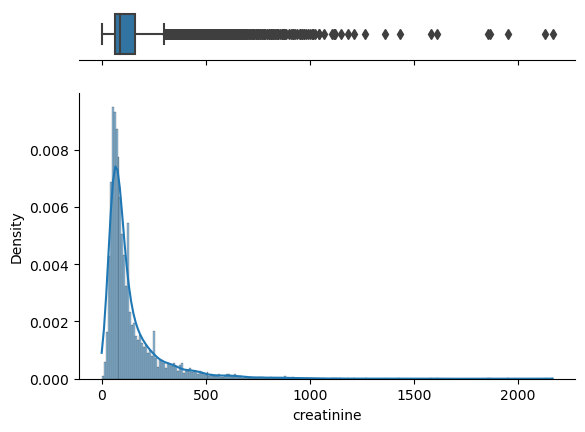

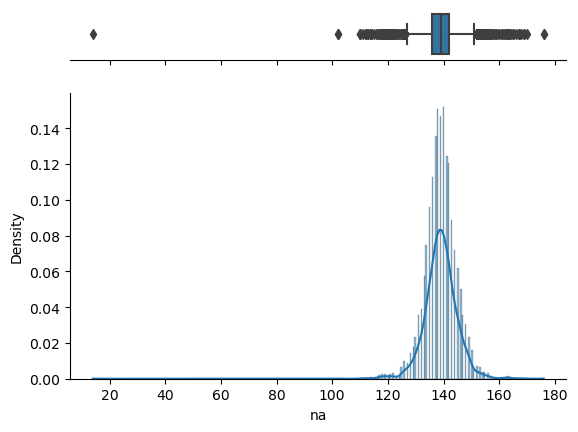

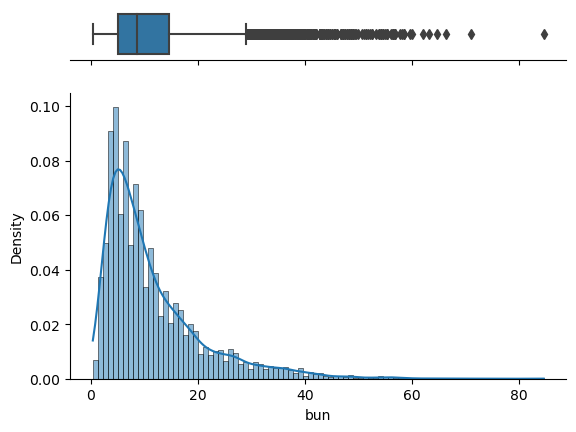

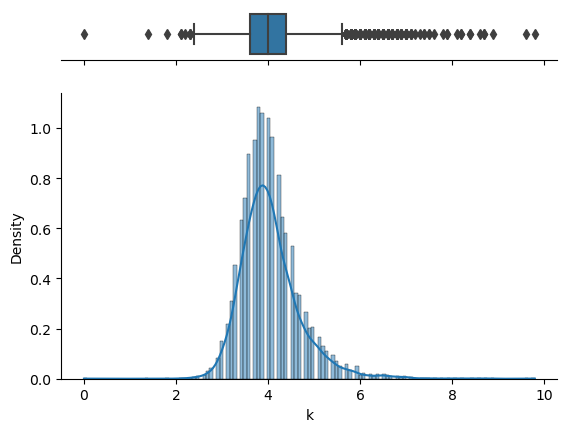

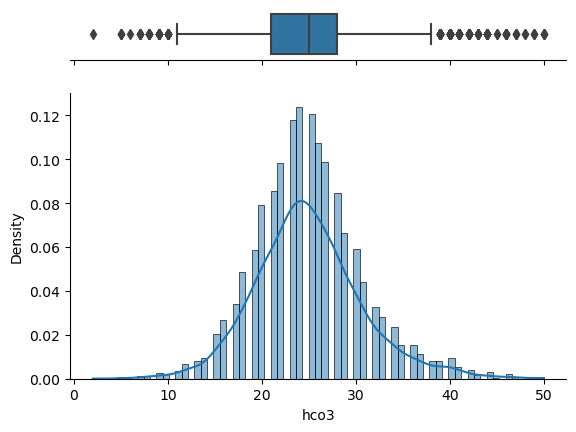

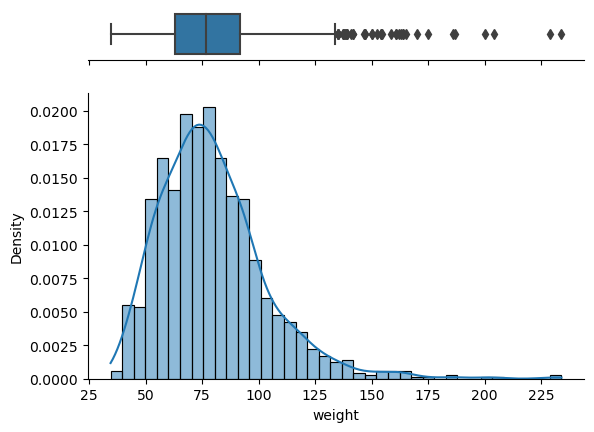

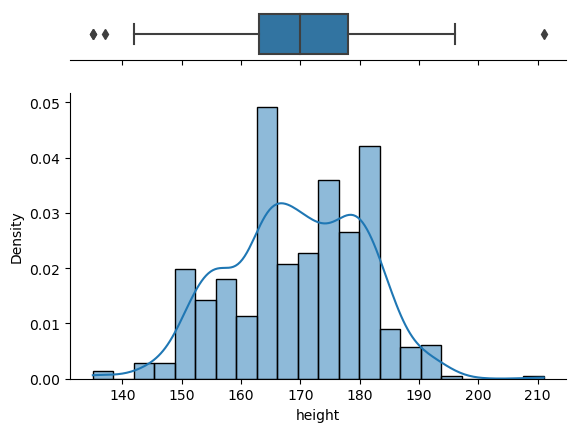

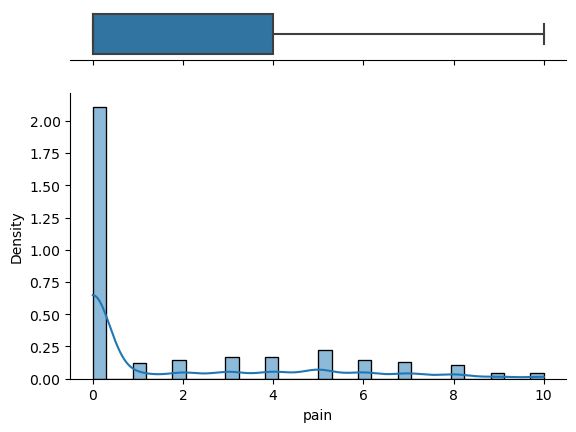

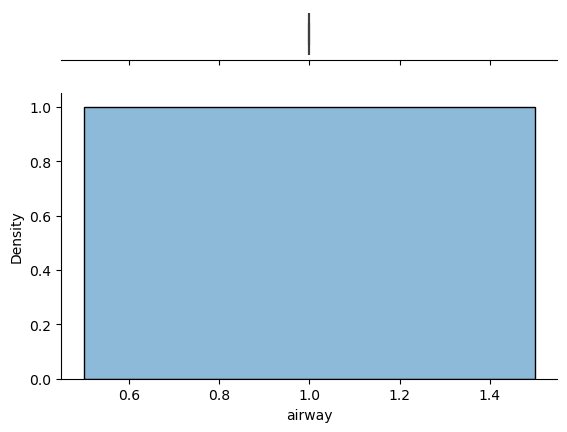

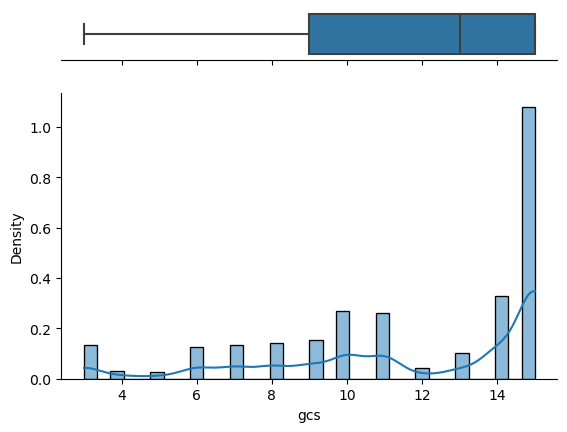

In [28]:
%%time
for x_var in df.VARIABLE.unique():
    hist_box_plot(df[df.VARIABLE==x_var].VALUENUM, x_var, frac_samples = 0.1)

**Height**

The height distribution looks more spiky than expected. Lets inspect closer the 'normal' portion of the graph, between 120-210 cm

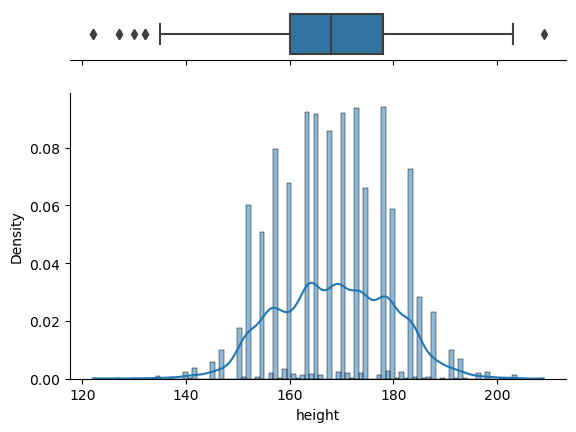

In [29]:
# group by icustay_id - one height measurement for each patient (for that stay)
df_heights = df[(df.VARIABLE.isin(['height']))].groupby('ICUSTAY_ID',as_index=False).agg(height=('VALUENUM',np.random.choice))

hist_box_plot(df_heights[df_heights.height.between(120,210)].height,'height',bins=100, frac_samples=1)

There appears to be a bias to certain values, possibly due to rounding/human error from the nurse/doctor who takes the measurements.

Lets check out the most frequent values:

In [30]:
df_heights.height.value_counts()

height
178.00    500
173.00    497
163.00    492
170.00    489
165.00    487
         ... 
186.00      1
194.00      1
244.00      1
211.00      1
162.56      1
Name: count, Length: 71, dtype: int64

The most common values seem somewhat random for measurements in cm. Perhaps they were measured in inches and then converted?

In [31]:
df_heights = df_heights.rename(columns={'height': 'height_cm'})
df_heights['height_inches'] = df_heights['height_cm'] / 2.54
df_heights

,ICUSTAY_ID,height_cm,height_inches
0,200001.0,170.0,66.929134
1,200033.0,173.0,68.110236
2,200038.0,183.0,72.047244
3,200050.0,165.0,64.960630
4,200053.0,188.0,74.015748
...,...,...,...
6117,299820.0,188.0,74.015748
6118,299847.0,178.0,70.078740
6119,299883.0,173.0,68.110236
6120,299950.0,152.0,59.842520


When converted to inches it seems plausible that the measurements were taken to the nearest inch and then converted to cm. We can see this because the majority of the measurements are very close to an exact number of inches.

It may be appropriate to filter the height measurements to give a smoother distribution here???

### Add columns for admisison-level data

**Weight and height** - these measurements are taken before ICU usually

In [32]:
df_weights = df[(df.VARIABLE.isin(['weight']))].groupby('ICUSTAY_ID',as_index=False).agg(weight=('VALUENUM',np.random.choice))
df = df.merge(df_weights,on='ICUSTAY_ID',how='left')

df_heights = df[(df.VARIABLE.isin(['height']))].groupby('ICUSTAY_ID',as_index=False).agg(height=('VALUENUM',np.random.choice))
df = df.merge(df_heights,on='ICUSTAY_ID',how='left')

df = df[~df.VARIABLE.isin(['weight','height'])] # remove weight and height measurements - only single admission level value needed

**Callout (RFD)**

We now extract the CALLOUT times (RFD flags) for each icustay and add these to the data:

For each ICUSTAY want to get the corresponding successful CALLOUTs (only those with outcomes marked as 'Discharged'). There are a small number of stays with mutliple succesful discharges, we remove these instances from the data to avoid confusion (they correspond the patients being transfered between different ICUs).

In [33]:
callout = pd.read_pickle('pickle_vars/callout.pkl.xz')

In [34]:
_stays = df.groupby(['ICUSTAY_ID'],as_index=False).agg(HADM_ID=('HADM_ID',np.random.choice),
                                                       IN=('INTIME',np.random.choice),
                                                       OUT=('OUTTIME',np.random.choice))
_stays_join = _stays.merge(callout, on='HADM_ID')
_stays_join['RFD'] = _stays_join['CREATETIME'].apply(lambda ti: ti.replace(tzinfo=None))
_stays_join['callout_match'] = _stays_join.apply(lambda row: 1 if (row['RFD']>=row['IN'] and row['RFD']<=row['OUT']) else 0,axis=1)
counts = _stays_join[(_stays_join['callout_match']==1) * (_stays_join['CALLOUT_OUTCOME']=='Discharged')].groupby('ICUSTAY_ID',as_index=False).agg(count_RFD=('RFD',pd.Series.count))
print("There are %d stays with more than one successful CALLOUT (i.e. transfers)." %sum(counts['count_RFD']>1))

There are 208 stays with more than one successful CALLOUT (i.e. transfers).


Remove these stays:

In [35]:
remove_stays = counts[counts['count_RFD']>1]['ICUSTAY_ID']
_stays_join = _stays_join[(_stays_join['callout_match']==1) * (_stays_join['CALLOUT_OUTCOME']=='Discharged')]
_stays_join = _stays_join[~_stays_join.ICUSTAY_ID.isin(remove_stays)]

In [36]:
print("Of the original %d icu stays," %df['ICUSTAY_ID'].nunique())
print("%d remain (have successful single callouts)" %_stays_join['ICUSTAY_ID'].nunique())

Of the original 14432 icu stays,
11288 remain (have successful single callouts)


Note: successful discharge here is different to "positive outcome" follwoing discharge. Successful simply means the patient did actually leave the icu (i.e. the callout was acted upon)

We now join the CALLOUTS (RFD flags) to the original data:


In [37]:
df = df.merge(_stays_join[['ICUSTAY_ID', 'RFD']], on='ICUSTAY_ID')

**Hours before callout**

We now add a column 'hrs_bRFD':

This is similar to the column 'hrs_bd' which we added previoulsy. We will filter on this column later to construct the feature matrix.



In [43]:
df['hrs_bRFD'] = (df['RFD'] - df['CHARTTIME']).dt.total_seconds()/3600

**Adjust length of stay to be between admission and callout**

In [18]:
df['LOS_AC'] = (df['RFD'] - df['INTIME']).dt.total_seconds()/(3600*24)

**Save data**

In [28]:
print("There are a total of %d rows in the cleaned data." %len(df))

There are a total of 5487647 rows in the cleaned data.


In [29]:
df.to_pickle('pickle_vars/all_data_cleaned.pkl.xz')